In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import punzinet

In [2]:
matplotlib.rcParams['figure.figsize'] = [8.0, 5.5]
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 15

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
mass_range = np.arange(100, 8800, 200)
seed = 21  # Have always the same results

if seed is not None:
    print(f'seed: {seed}')
    torch.manual_seed(seed)
    np.random.seed(seed)
else:
    print('random seed')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f'using {device}')

seed: 21
using cuda:0


In [5]:
features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']

# frac = 0.1
frac = 1

# global settings
target_lumi = 50  # target luminosity in 1/fb
scaling = 0.9  # for example trigger efficiency

mc_types = ['taupair', 'mumu', 'eemumu']
mc_lumis = [1500, 450, 1000]
n_gen_signal = 20_000 * frac  # generated signal events per mass hypothesis
scale = {type: target_lumi / lumi_mc / frac for type, lumi_mc in zip(mc_types, mc_lumis)}
scale.update({str(mass) + 'MeV': 1 for mass in np.arange(100, 10400, 100)})

# bin withs in recoil mass squared
widths = punzinet.prepare.bin_widths('width.txt')

In [6]:
# import training data
df = pd.read_feather('training_data.feather').sample(frac=frac)
# df.to_feather(path)

# choose mass range of generated signal events, removes a lot of events
punzinet.prepare.set_range_index(df, mass_range, widths, n_sigma=2)
print(len(df))
df = df[(1 + df.range_idx_high - df.range_idx_low) != 0]
print(len(df))
df['sig_m_range'] = (df.gen_mass.map({mass: 1 for mass in mass_range}) == 1).astype('int')

# set weights
punzinet.prepare.set_weights(df, scale)

list(df)

8410413
5464515


['feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'category',
 'M2',
 'gen_mass',
 'labels',
 'M',
 'signal',
 'sig_m_range',
 'range_idx_low',
 'range_idx_high',
 'weights']

In [7]:
X = df[features].values
df[features].describe()

,feature_1,feature_2,feature_3,feature_4
count,5.464515e+06,5.464515e+06,5.464515e+06,5.464515e+06
mean,1.925875e-01,3.050561e-01,3.638465e-01,2.456116e-01
std,1.036029e-01,1.587504e-01,1.824939e-01,1.963399e-01
min,5.057512e-04,2.881988e-03,-1.805686e-01,5.676633e-08
25%,1.222531e-01,1.997650e-01,2.252350e-01,8.319260e-02
50%,1.828042e-01,2.740788e-01,3.328819e-01,1.958608e-01
75%,2.455923e-01,3.804578e-01,4.721695e-01,3.715830e-01
max,9.894678e-01,1.002341e+00,1.306347e+00,1.007141e+00


In [8]:
print(df.category.value_counts()[:3])
print('norm', 1 / df.weights.values.mean())

taupair    4561634
eemumu      530100
mumu         40125
Name: category, dtype: int64
norm 14.928918812980704


In [9]:
class Net(nn.Module):
    def __init__(self, n_inputs):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(n_inputs, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


net = Net(len(features))
net.apply(punzinet.train.weights_init)

Net(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)

In [10]:
bce_batch_size = 2**12
print(f'total length dataframe: {len(df)}')
print(f'iterations per epoch: {math.ceil(len(df) / bce_batch_size)}')

total length dataframe: 5464515
iterations per epoch: 1335


# first training

In [11]:
net, bce_loss_list = punzinet.train.bce_training(df, X, net, 
                                                 device='cpu', 
                                                 epochs=150, 
                                                 batch_size=bce_batch_size, 
                                                 lr=1)

training on cpu


[89,  1335] loss: 0.39546:  59%|█████▉    | 89/150 [03:24<02:22,  2.34s/epochs]

Epoch    89: reducing learning rate of group 0 to 5.0000e-01.


[104,  1335] loss: 0.39388:  69%|██████▉   | 104/150 [03:59<01:46,  2.32s/epochs]

Epoch   104: reducing learning rate of group 0 to 2.5000e-01.


[124,  1335] loss: 0.39346:  83%|████████▎ | 124/150 [04:44<00:58,  2.24s/epochs]

Epoch   124: reducing learning rate of group 0 to 1.2500e-01.


[139,  1335] loss: 0.39317:  93%|█████████▎| 139/150 [05:17<00:23,  2.14s/epochs]

Epoch   139: reducing learning rate of group 0 to 6.2500e-02.


[150,  1335] loss: 0.39310: 100%|██████████| 150/150 [05:40<00:00,  2.27s/epochs]


Text(0, 0.5, 'loss (BCE)')

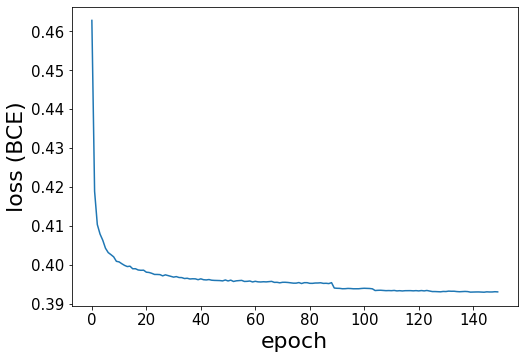

In [12]:
plt.plot(bce_loss_list)
plt.xlabel('epoch')
plt.ylabel('loss (BCE)')

In [13]:
net.cpu()

# torch.save(net.state_dict(), 'bce_net.pt')
# net.load_state_dict(torch.load('bce_net.pt'))

output = net(torch.from_numpy(X))

iteration through cut values in steps of 20: 100%|██████████| 10/10 [00:24<00:00,  2.45s/block]


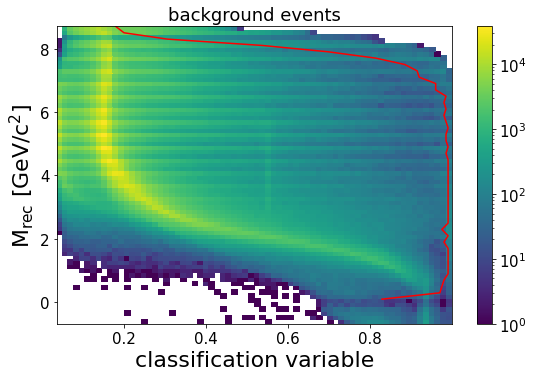

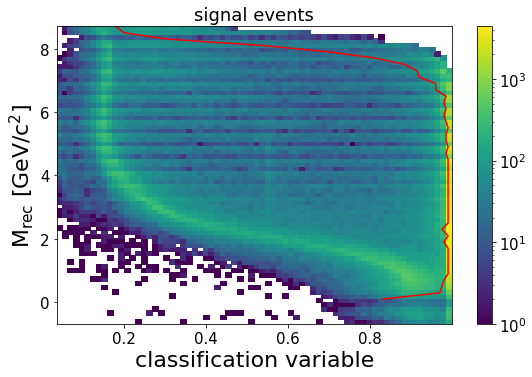

In [14]:
opt_cut_bce, opt_fom_bce = punzinet.fom.optimal_cut(df, output, widths, mass_range, n_gen_signal, scaling=scaling)
punzinet.plot.output_distribution(df, net, X, cut_overlay=opt_cut_bce, mass_range=mass_range)

# second training

In [15]:
net, punzi_loss_list = punzinet.train.punzi_training(df, X, net, len(mass_range), n_gen_signal, target_lumi,  
                                                     device=device, 
                                                     epochs=500, 
                                                     lr=0.05,
                                                     scaling=scaling)

training on cuda:0


[210] loss: 10.12459:  42%|████▏     | 210/500 [00:15<00:19, 14.80epochs/s]

Epoch   208: reducing learning rate of group 0 to 2.5000e-02.


[500] loss: 9.83947: 100%|██████████| 500/500 [00:38<00:00, 12.93epochs/s] 


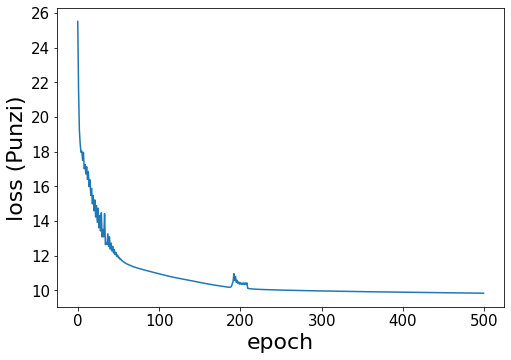

In [16]:
plt.plot(np.array(punzi_loss_list))
plt.xlabel('epoch')
plt.ylabel('loss (Punzi)')
plt.show()

In [17]:
net.cpu()

# torch.save(net.state_dict(), 'punzi_net.pt')
# net.load_state_dict(torch.load('bce_net.pt'))

output = net(torch.from_numpy(X))

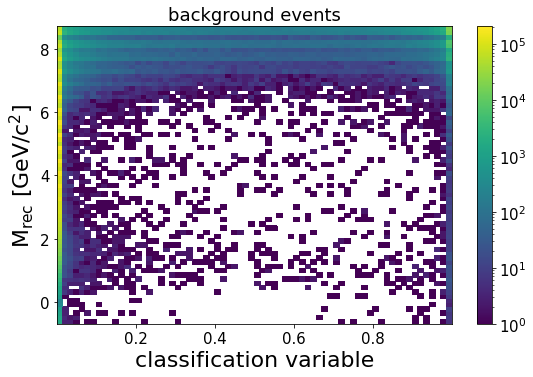

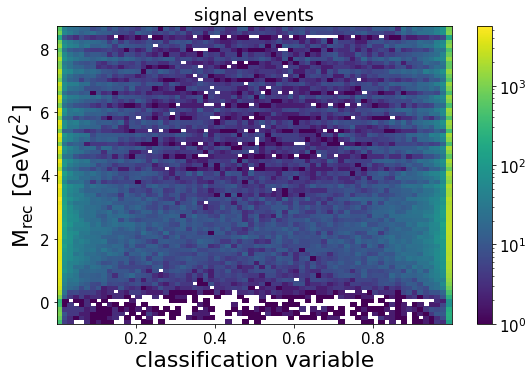

In [18]:
punzinet.plot.output_distribution(df, net, X)

In [19]:
opt_cut_punzi, opt_fom_punzi = punzinet.fom.optimal_cut(df, output, widths, mass_range, n_gen_signal, scaling=scaling)
fom_fixed_cut = punzinet.fom.fixed_cut(df, output, widths, mass_range, n_gen_signal, cut=0.5, scaling=scaling)

iteration through cut values in steps of 20: 100%|██████████| 10/10 [00:07<00:00,  1.28block/s]


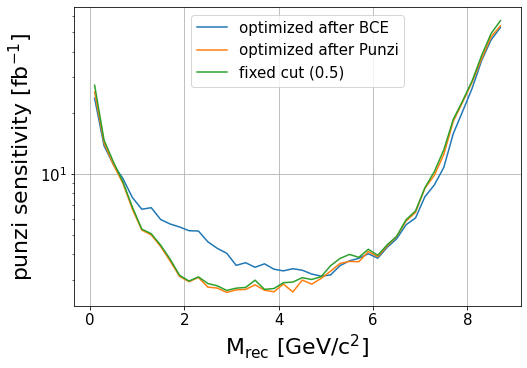

In [20]:
plt.plot(mass_range / 1000, opt_fom_bce, label='optimized after BCE')
plt.plot(mass_range / 1000, opt_fom_punzi, label='optimized after Punzi')
plt.plot(mass_range / 1000, fom_fixed_cut, label='fixed cut (0.5)')
plt.legend()
plt.grid(True)
plt.gca().set_axisbelow(True)
plt.ylabel('punzi sensitivity [fb$^{-1}$]')
plt.xlabel(r'M$_{\sf{rec}}$ [GeV/c$^2$]')
plt.yscale('log')